<a href="https://colab.research.google.com/github/ghadfield32/Deep_learning/blob/main/TinVGG_temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch
!pip install matplotlib
!pip install scikit-learn


In [2]:
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
#input important functions for visualization, accuracy, loss,
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [4]:
# Define hyperparameters
learning_rate = 0.001
momentum = 0.9
batch_size = 64
num_epochs = 20

100%|██████████| 170498071/170498071 [00:03<00:00, 44299172.31it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
image in dataset = 50000


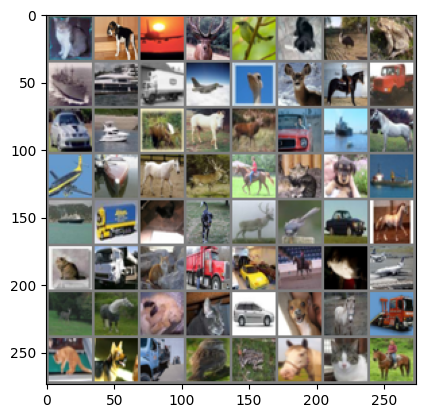

In [5]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
number_of_images = len(dataset)
print("image in dataset =", number_of_images)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Split the training dataset into training and validation subsets
train_len = int(0.8 * len(dataset))  # 80% for training
val_len = len(dataset) - train_len  # 20% for validation
train_subset, val_subset = random_split(dataset, [train_len, val_len])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)


#Visualize the Dataset
# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)


# Show images
imshow(torchvision.utils.make_grid(images))


# Automatically get the number of classes and input dimensions from the dataset
num_classes = len(dataset.classes)
input_channels = dataset[0][0].size(0)
input_height = dataset[0][0].size(1)
input_width = dataset[0][0].size(2)

In [6]:

class TinyVGG(nn.Module):
    def __init__(self, input_channels, input_height, input_width, num_classes=1000): #number of classes is a random number (used because imagenet has a 1000 classes, can be changed when using)
        super(TinyVGG, self).__init__()

        # Block 1
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Block 2
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Compute the dimensions for the fully connected layer
        self.fc_input_dim = self._get_fc_input_dim(input_channels, input_height, input_width)

        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_dim, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )

    def _get_fc_input_dim(self, input_channels, input_height, input_width):
        # Mock forward pass to get the size of the flattened features
        x = torch.randn(1, input_channels, input_height, input_width)
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(x.size(0), -1)
        return x.size(1)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        return x



In [7]:
# Instantiate the model
tiny_vgg = TinyVGG(input_channels=input_channels, input_height=input_height, input_width=input_width, num_classes=num_classes)

# Specify the loss function and the optimizer using the defined hyperparameters
criterion = nn.CrossEntropyLoss() #BCEwithlogitloss for binary classification
optimizer = optim.SGD(tiny_vgg.parameters(), lr=learning_rate, momentum=momentum)


In [8]:
# Training Phase
for epoch in range(num_epochs):
    tiny_vgg.train()  # Set the model to training mode
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = tiny_vgg(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation phase at the end of each epoch
    tiny_vgg.eval()  # Set the model to evaluation mode
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            outputs = tiny_vgg(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_accuracy = 100 * correct_val / total_val
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.3f}, Validation Accuracy: {val_accuracy:.2f}%')

print("Finished Training")

Epoch 1, Loss: 1.993, Validation Accuracy: 38.39%
Epoch 2, Loss: 1.646, Validation Accuracy: 45.17%
Epoch 3, Loss: 1.472, Validation Accuracy: 50.54%
Epoch 4, Loss: 1.360, Validation Accuracy: 52.84%
Epoch 5, Loss: 1.279, Validation Accuracy: 56.25%
Epoch 6, Loss: 1.211, Validation Accuracy: 57.29%
Epoch 7, Loss: 1.151, Validation Accuracy: 59.64%
Epoch 8, Loss: 1.101, Validation Accuracy: 60.90%
Epoch 9, Loss: 1.049, Validation Accuracy: 62.03%
Epoch 10, Loss: 1.003, Validation Accuracy: 63.47%
Epoch 11, Loss: 0.959, Validation Accuracy: 64.75%
Epoch 12, Loss: 0.913, Validation Accuracy: 64.55%
Epoch 13, Loss: 0.874, Validation Accuracy: 66.56%
Epoch 14, Loss: 0.839, Validation Accuracy: 66.12%
Epoch 15, Loss: 0.800, Validation Accuracy: 67.73%
Epoch 16, Loss: 0.758, Validation Accuracy: 67.99%
Epoch 17, Loss: 0.722, Validation Accuracy: 68.93%
Epoch 18, Loss: 0.683, Validation Accuracy: 69.95%
Epoch 19, Loss: 0.646, Validation Accuracy: 70.21%
Epoch 20, Loss: 0.610, Validation Accura

Accuracy of the network on the 50000 test images: 80.81%


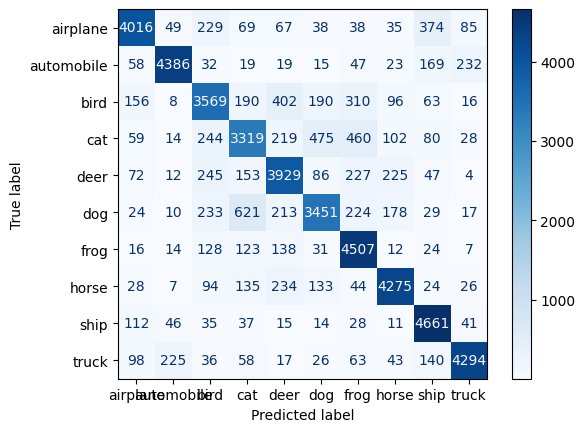

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Testing phase
tiny_vgg.eval()  # Set the model to evaluation mode
correct = 0
total = 0

# Initialize variables to hold the true and predicted labels
all_labels = np.array([])
all_preds = np.array([])

with torch.no_grad():  # Disable gradient computation
    for data in loader:
        images, labels = data
        outputs = tiny_vgg(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Append the labels and predictions for this batch to the arrays
        all_labels = np.append(all_labels, labels.numpy())
        all_preds = np.append(all_preds, predicted.numpy())

# Compute accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the network on the {number_of_images} test images: {accuracy:.2f}%')

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(include_values=True, cmap=plt.cm.Blues, ax=None, xticks_rotation='horizontal')
plt.show()


Original Image:


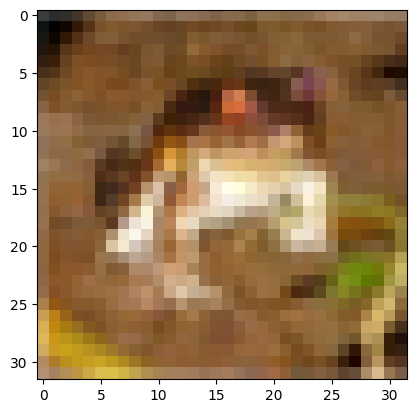

Predicted Class: frog


In [11]:
#Visualize one of the images
# Define a function to unnormalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def visualize_prediction(image, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        x = image.unsqueeze(0)  # Add a batch dimension
        outputs = model(x)
        _, predicted = torch.max(outputs.data, 1)
        predicted_class = dataset.classes[predicted[0]]

    # Display the original image
    print("Original Image:")
    imshow(image)

    # Display the predicted class
    print(f"Predicted Class: {predicted_class}")

# Choose an image to visualize
image = dataset[0][0]

# Visualize the image and prediction
visualize_prediction(image, tiny_vgg)


In [12]:
from pathlib import Path
import torch

# Create models directory (if it doesn't already exist)
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "tiny_vgg_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=tiny_vgg.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)


Saving model to: models/tiny_vgg_model.pth
